<a href="https://colab.research.google.com/github/jiho-kang/DL_CNN_STUDY/blob/main/11_CatnDog_Sequence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 개와 고양이 데이터 세트의 디렉토리와 파일을 기반으로 메타 정보용 DataFrame 생성 

In [ ]:
from google.colab import drive
import json
import os

drive.mount('./drive')

api_key_path = './drive/MyDrive/kaggle.json'

with open(api_key_path) as f:
  api = json.load(f)
  os.environ['KAGGLE_USERNAME'] = api['username']
  os.environ['KAGGLE_KEY'] = api['key']

Mounted at ./drive


In [ ]:
! kaggle datasets download -d tongpython/cat-and-dog
!unzip "/content/cat-and-dog.zip" -d cat-and-dog

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

def make_catndog_dataframe():
    paths = []
    dataset_gubuns = []
    label_gubuns = []
    # os.walk()를 이용하여 특정 디렉토리 밑에 있는 모든 하위 디렉토리를 모두 조사. 
    # cat-and-dog 하위 디렉토리 밑에 jpg 확장자를 가진 파일이 모두 이미지 파일임
    # cat-and-dog 밑으로 /train/, /test/ 하위 디렉토리 존재(학습, 테스트 용 이미지 파일들을 가짐)

    for dirname, _, filenames in os.walk('/content/cat-and-dog'):
        for filename in filenames:
            # 이미지 파일이 아닌 파일도 해당 디렉토리에 있음.
            if '.jpg' in filename:
                # 파일의 절대 경로를 file_path 변수에 할당. 
                file_path = dirname+'/'+ filename
                paths.append(file_path)
                # 파일의 절대 경로에 training_set, test_set가 포함되어 있으면 데이터 세트 구분을 'train'과 'test'로 분류. 
                if '/training_set/' in file_path:
                    dataset_gubuns.append('train')  
                elif '/test_set/' in file_path:
                    dataset_gubuns.append('test')
                else: dataset_gubuns.append('N/A')

                # 파일의 절대 경로에 dogs가 있을 경우 해당 파일은 dog 이미지 파일이고, cats일 경우는 cat 이미지 파일임. 
                if 'dogs' in file_path:
                    label_gubuns.append('DOG')
                elif 'cats' in file_path:
                    label_gubuns.append('CAT')
                else: label_gubuns.append('N/A')
    
    data_df = pd.DataFrame({'path':paths, 'dataset':dataset_gubuns, 'label':label_gubuns})
    return data_df

In [ ]:
pd.set_option('display.max_colwidth', 200)
data_df = make_catndog_dataframe()
print('data_df shape:', data_df.shape)
data_df.head()

data_df shape: (10028, 3)


,path,dataset,label
0,/content/cat-and-dog/test_set/test_set/dogs/dog.4713.jpg,test,DOG
1,/content/cat-and-dog/test_set/test_set/dogs/dog.4797.jpg,test,DOG
2,/content/cat-and-dog/test_set/test_set/dogs/dog.4943.jpg,test,DOG
3,/content/cat-and-dog/test_set/test_set/dogs/dog.4471.jpg,test,DOG
4,/content/cat-and-dog/test_set/test_set/dogs/dog.4269.jpg,test,DOG


## Keras Sequence를 상속받은 Dataset 객체를 생성

In [ ]:
list_a = [1, 2, 3, 4, 5]
print(len(list_a)) # __len__(self) 호출
print(list_a[0]) # __getitem__(self, index)

5
1


In [ ]:
from tensorflow.keras.utils import Sequence
import sklearn 
import cv2

# 배치 크기와 이미지 크기를 전역 변수로 선언 
BATCH_SIZE = 64
IMAGE_SIZE = 224

# 입력 인자 image_filenames, labels는 모두 numpy array로 들어옴. 
class CnD_Dataset(Sequence):
    
    # 객체 생성 인자로 들어온 값을 객체 내부 변수로 할당.
    def __init__(self, image_filenames, labels, batch_size=BATCH_SIZE, augmentor=None, shuffle=False):
        '''
        파라미터 설명
        image_filenames: opencv로 image를 로드할 파일의 절대 경로들
        labels: 해당 image의 label들
        batch_size: __getitem__(self, index) 호출 시 마다 가져올 데이터 batch 건수
        augmentor: albumentations 객체
        shuffle: 학습 데이터의 경우 epoch 종료시마다 데이터를 섞을지 여부
        '''
        # 객체 생성 인자로 들어온 값을 객체 내부 변수로 할당. 
        self.image_filenames = image_filenames
        self.labels = labels
        self.batch_size = batch_size
        self.augmentor = augmentor
        self.shuffle = shuffle
        # train data의 경우 
        if self.shuffle:
            # 객체 생성시에 한번 데이터를 섞음. 
            #self.on_epoch_end()
            pass
            
    # Sequence를 상속받은 Dataset은 batch_size 단위로 입력된 데이터를 처리함. 
    # steps_per_epoch 계산
    def __len__(self):
        # batch_size단위로 데이터를 몇번 가져와야하는지 계산하기 위해 전체 데이터 건수를 batch_size로 나누되, 정수로 정확히 나눠지지 않을 경우 1회를 더한다.
        return int(np.ceil(len(self.labels)/self.batch_size))

    # index: n번째 epoch의 데이터를 batch_size 만큼 가져와서 가공하여 반환        
    def __getitem__(self, index):
    # batch_size 단위로 image_array, label_array 데이터를 가져와서 변환한 뒤 다시 반환함
    # 인자로 몇번째 batch 인지를 나타내는 index를 입력하면 해당 순서에 해당하는 batch_size 만큼의 데이타를 가공하여 반환
    # batch_size 갯수만큼 변환된 image_array와 label_array 반환. 
    
        # index는 몇번째 batch인지를 나타냄. 
        # batch_size만큼 순차적으로 데이터를 가져오려면 array에서 index*self.batch_size:(index+1)*self.batch_size 만큼의 연속 데이터를 가져오면 됨
        image_name_batch = self.image_filenames[index*self.batch_size:(index+1)*self.batch_size]
        if self.labels is not None:
            label_batch = self.labels[index*self.batch_size:(index+1)*self.batch_size] # 밖에서 원핫되어 들여보내자
        
        # 만일 객체 생성 인자로 albumentation으로 만든 augmentor가 주어진다면 아래와 같이 augmentor를 이용하여 image 변환
        # albumentations은 개별 image만 변환할 수 있으므로 batch_size만큼 할당된 image_name_batch를 한 건씩 iteration하면서 변환 수행. 
        # image_batch 배열은 float32 로 설정. 
        image_batch = np.zeros((image_name_batch.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3)) # batch_size로 가져오면 안되고, 마지막 epoch에서 돌아갈 데이터도 생각하여 shape[0]를 가져와야 함.
        # batch_size에 담긴 건수만큼 iteration 하면서 opencv image load -> image augmentation 변환(augmentor가 not None일 경우)-> image_batch에 담음.
        for image_index in range(image_name_batch.shape[0]):
            image = cv2.cvtColor(cv2.imread(image_name_batch[image_index]), cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
            if self.augmentor is not None:
                image = self.augmentor(image=image)['image']
        
            image_batch[image_index] = image
       
        return image_batch, label_batch
            
            
    # epoch가 한번 수행이 완료 될 때마다 모델의 fit()에서 호출됨. 
    def on_epoch_end(self):
        if(self.shuffle):
            #print('epoch end')
            # 전체 image 파일의 위치와 label를 쌍을 맞춰서 섞어준다. scikt learn의 utils.shuffle에서 해당 기능 제공
            self.image_filenames, self.labels = sklearn.utils.shuffle(self.image_filenames, self.labels)
        else:
            pass

### Sequence 기반 Dataset을 생성하고 호출하기
* albumentations를 이용하여 BATCH 크기 만큼 데이터를 Augmentation 한 뒤 데이터를 반환 할 수 있는 Sequence 기반 Dataset을 생성하고 호출하기 

In [ ]:
data_df.head()

,path,dataset,label
0,/content/cat-and-dog/test_set/test_set/dogs/dog.4713.jpg,test,DOG
1,/content/cat-and-dog/test_set/test_set/dogs/dog.4797.jpg,test,DOG
2,/content/cat-and-dog/test_set/test_set/dogs/dog.4943.jpg,test,DOG
3,/content/cat-and-dog/test_set/test_set/dogs/dog.4471.jpg,test,DOG
4,/content/cat-and-dog/test_set/test_set/dogs/dog.4269.jpg,test,DOG


In [ ]:
import albumentations as A

# 전체 데이터 세트에서 학습과 테스트용 메타 정보 DataFrame 생성. 
train_df = data_df[data_df['dataset']=='train']
test_df = data_df[data_df['dataset']=='test']

# image file의 위치가 있는 데이터와 label값을 numpy array로 변환. 
train_image_filenames = train_df['path'].values
train_image_labels = train_df['label'].values

cnd_augmentor = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.5)
])

# Sequence를 상속받은 CnD_Dataset을 image 파일 위치, label값, albumentations 변환 객체를 입력하여 생성. 
cnd_ds = CnD_Dataset(train_image_filenames, train_image_labels, batch_size=BATCH_SIZE, augmentor=cnd_augmentor, shuffle=False)

In [ ]:
train_image_filenames.shape

(8005,)

In [ ]:
#next(iter(cnd_ds))
images_batch = next(iter(cnd_ds))[0]
labels_batch = next(iter(cnd_ds))[1]
print(images_batch.shape, labels_batch.shape)
print(images_batch[0])

(64, 224, 224, 3) (64,)
[[[ 82.  89.  82.]
  [ 74.  85.  79.]
  [ 81.  94.  87.]
  ...
  [130. 128. 115.]
  [ 50.  49.  43.]
  [  2.   2.  13.]]

 [[ 78.  85.  78.]
  [ 74.  85.  79.]
  [ 82.  95.  88.]
  ...
  [111. 109.  96.]
  [112. 112. 104.]
  [ 24.  26.  30.]]

 [[ 86.  92.  86.]
  [ 84.  95.  89.]
  [ 83.  96.  89.]
  ...
  [ 55.  53.  40.]
  [122. 123. 109.]
  [ 97. 101.  89.]]

 ...

 [[216. 223. 218.]
  [214. 224. 218.]
  [184. 198. 192.]
  ...
  [ 38.  40.  27.]
  [ 36.  38.  23.]
  [ 35.  41.  19.]]

 [[168. 173. 166.]
  [164. 171. 163.]
  [157. 170. 160.]
  ...
  [ 40.  42.  29.]
  [ 37.  38.  24.]
  [ 34.  37.  16.]]

 [[222. 225. 215.]
  [183. 191. 180.]
  [173. 183. 172.]
  ...
  [ 42.  44.  31.]
  [ 40.  41.  26.]
  [ 37.  39.  17.]]]


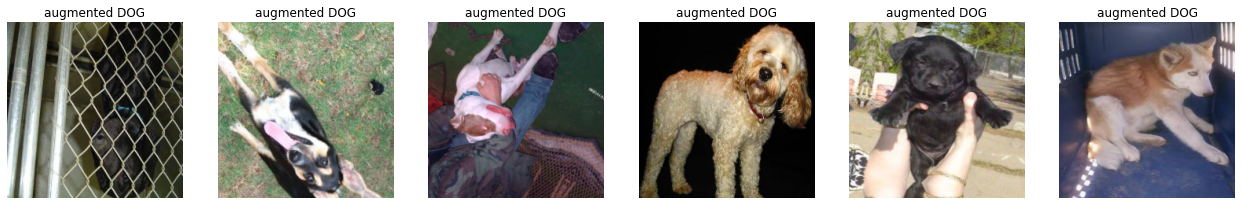

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline 

def show_grid_images(images_batch, ncols=4, title=None):
    figure, axs = plt.subplots(figsize=(22, 4), nrows=1, ncols=ncols)
    for i in range(ncols):
        # image_batch는 float형이므로 int형으로 변경하여 이미지 시각화
        axs[i].imshow(np.array(images_batch[i], dtype='int32'))
        axs[i].axis('off')
        axs[i].set_title(title[i]) 
        
show_grid_images(images_batch, ncols=6, title='augmented ' + labels_batch)

### 원본 이미지 픽셀값의 scaling을 감안하여 다시 CnD_Dataset 재 작성. 
- image = image/255.0 한 줄만 넣음

In [ ]:
# 입력 인자 image_filenames, labels는 모두 numpy array로 들어옴. 
class CnD_Dataset(Sequence):
    def __init__(self, image_filenames, labels, batch_size=BATCH_SIZE, augmentor=None, shuffle=False):
        '''
        파라미터 설명
        image_filenames: opencv로 image를 로드할 파일의 절대 경로들
        labels: 해당 image의 label들
        batch_size: __getitem__(self, index) 호출 시 마다 가져올 데이터 batch 건수
        augmentor: albumentations 객체
        shuffle: 학습 데이터의 경우 epoch 종료시마다 데이터를 섞을지 여부
        '''
        # 객체 생성 인자로 들어온 값을 객체 내부 변수로 할당. 
        self.image_filenames = image_filenames
        self.labels = labels
        self.batch_size = batch_size
        self.augmentor = augmentor
        # train data의 경우 
        self.shuffle = shuffle
        if self.shuffle:
            # 객체 생성시에 한번 데이터를 섞음. 
            #self.on_epoch_end()
            pass
    
    # Sequence를 상속받은 Dataset은 batch_size 단위로 입력된 데이터를 처리함. 
    # __len__()은 전체 데이터 건수가 주어졌을 때 batch_size단위로 몇번 데이터를 반환하는지 나타남
    def __len__(self):
        # batch_size단위로 데이터를 몇번 가져와야하는지 계산하기 위해 전체 데이터 건수를 batch_size로 나누되, 정수로 정확히 나눠지지 않을 경우 1회를 더한다. 
        return int(np.ceil(len(self.labels)/self.batch_size))
    
    # batch_size 단위로 image_array, label_array 데이터를 가져와서 변환한 뒤 다시 반환함
    # 인자로 몇번째 batch 인지를 나타내는 index를 입력하면 해당 순서에 해당하는 batch_size 만큼의 데이타를 가공하여 반환
    # batch_size 갯수만큼 변환된 image_array와 label_array 반환. 
    def __getitem__(self, index):
        # index는 몇번째 batch인지를 나타냄. 
        # batch_size만큼 순차적으로 데이터를 가져오려면 array에서 index*self.batch_size:(index+1)*self.batch_size 만큼의 연속 데이터를 가져오면 됨
        image_name_batch = self.image_filenames[index*self.batch_size:(index+1)*self.batch_size]
        if self.labels is not None:
            label_batch = self.labels[index*self.batch_size:(index+1)*self.batch_size]
        
        # 만일 객체 생성 인자로 albumentation으로 만든 augmentor가 주어진다면 아래와 같이 augmentor를 이용하여 image 변환
        # albumentations은 개별 image만 변환할 수 있으므로 batch_size만큼 할당된 image_name_batch를 한 건씩 iteration하면서 변환 수행. 
        # image_batch 배열은 float32 로 설정. 
        image_batch = np.zeros((image_name_batch.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3), dtype='float32')
        
        # batch_size에 담긴 건수만큼 iteration 하면서 opencv image load -> image augmentation 변환(augmentor가 not None일 경우)-> image_batch에 담음. 
        for image_index in range(image_name_batch.shape[0]):
            image = cv2.cvtColor(cv2.imread(image_name_batch[image_index]), cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
            if self.augmentor is not None:
                image = self.augmentor(image=image)['image']
            
            # 이미지 값을 0 ~ 1 로 스케일링. 
            image = image/255.0
                
            image_batch[image_index] = image
        
        return image_batch, label_batch
    
    # epoch가 한번 수행이 완료 될 때마다 모델의 fit()에서 호출됨. 
    def on_epoch_end(self):
        if(self.shuffle):
            #print('epoch end')
            # 전체 image 파일의 위치와 label를 쌍을 맞춰서 섞어준다. scikt learn의 utils.shuffle에서 해당 기능 제공
            self.image_filenames, self.labels = sklearn.utils.shuffle(self.image_filenames, self.labels)
        else:
            pass

In [ ]:
# Sequence를 상속받은 CnD_Dataset을 image 파일 위치, label값, albumentations 변환 객체를 입력하여 생성. 
cnd_ds = CnD_Dataset(train_image_filenames, train_image_labels, batch_size=BATCH_SIZE, augmentor=cnd_augmentor, shuffle=False)

images_batch = next(iter(cnd_ds))[0]
labels_batch = next(iter(cnd_ds))[1]
print(images_batch.shape, labels_batch.shape)
print(images_batch[0:2])

(64, 224, 224, 3) (64,)
[[[[0.32156864 0.34901962 0.32156864]
   [0.2901961  0.33333334 0.30980393]
   [0.31764707 0.36862746 0.34117648]
   ...
   [0.50980395 0.5019608  0.4509804 ]
   [0.19607843 0.19215687 0.16862746]
   [0.00784314 0.00784314 0.05098039]]

  [[0.30588236 0.33333334 0.30588236]
   [0.2901961  0.33333334 0.30980393]
   [0.32156864 0.37254903 0.34509805]
   ...
   [0.43529412 0.42745098 0.3764706 ]
   [0.4392157  0.4392157  0.40784314]
   [0.09411765 0.10196079 0.11764706]]

  [[0.3372549  0.36078432 0.3372549 ]
   [0.32941177 0.37254903 0.34901962]
   [0.3254902  0.3764706  0.34901962]
   ...
   [0.21568628 0.20784314 0.15686275]
   [0.47843137 0.48235294 0.42745098]
   [0.38039216 0.39607844 0.34901962]]

  ...

  [[0.84705883 0.8745098  0.85490197]
   [0.8392157  0.8784314  0.85490197]
   [0.72156864 0.7764706  0.7529412 ]
   ...
   [0.14901961 0.15686275 0.10588235]
   [0.14117648 0.14901961 0.09019608]
   [0.13725491 0.16078432 0.07450981]]

  [[0.65882355 0.6784

### Pretrained 모델에서 사용하는 보다 범용적인 Preprocessing을 적용할 수 있도록 재작성. 
* pre_func 인자를 추가하여 pretrained 모델의 preprocess_input 함수를 인자로 입력할 수 있도록 수정. 
- 밖에서 preprocess 함수가 들어오고, 이를 self.pre_func으로 넣는다.

In [ ]:
# 입력 인자 image_filenames, labels는 모두 numpy array로 들어옴. 
class CnD_Dataset(Sequence):
    def __init__(self, image_filenames, labels, batch_size=BATCH_SIZE, augmentor=None, shuffle=False, pre_func=None):
        '''
        파라미터 설명
        image_filenames: opencv로 image를 로드할 파일의 절대 경로들
        labels: 해당 image의 label들
        batch_size: __getitem__(self, index) 호출 시 마다 가져올 데이터 batch 건수
        augmentor: albumentations 객체
        shuffle: 학습 데이터의 경우 epoch 종료시마다 데이터를 섞을지 여부
        '''
        # 객체 생성 인자로 들어온 값을 객체 내부 변수로 할당. 
        self.image_filenames = image_filenames
        self.labels = labels
        self.batch_size = batch_size
        self.augmentor = augmentor
        self.pre_func = pre_func
        # train data의 경우 
        self.shuffle = shuffle
        if self.shuffle:
            # 객체 생성시에 한번 데이터를 섞음. 
            #self.on_epoch_end()
            pass
    
    # Sequence를 상속받은 Dataset은 batch_size 단위로 입력된 데이터를 처리함. 
    # __len__()은 전체 데이터 건수가 주어졌을 때 batch_size단위로 몇번 데이터를 반환하는지 나타남
    def __len__(self):
        # batch_size단위로 데이터를 몇번 가져와야하는지 계산하기 위해 전체 데이터 건수를 batch_size로 나누되, 정수로 정확히 나눠지지 않을 경우 1회를 더한다. 
        return int(np.ceil(len(self.labels)/self.batch_size))
    
    # batch_size 단위로 image_array, label_array 데이터를 가져와서 변환한 뒤 다시 반환함
    # 인자로 몇번째 batch 인지를 나타내는 index를 입력하면 해당 순서에 해당하는 batch_size 만큼의 데이타를 가공하여 반환
    # batch_size 갯수만큼 변환된 image_array와 label_array 반환. 
    def __getitem__(self, index):
        # index는 몇번째 batch인지를 나타냄. 
        # batch_size만큼 순차적으로 데이터를 가져오려면 array에서 index*self.batch_size:(index+1)*self.batch_size 만큼의 연속 데이터를 가져오면 됨
        image_name_batch = self.image_filenames[index*self.batch_size:(index+1)*self.batch_size]
        if self.labels is not None:
            label_batch = self.labels[index*self.batch_size:(index+1)*self.batch_size]
        
        # 만일 객체 생성 인자로 albumentation으로 만든 augmentor가 주어진다면 아래와 같이 augmentor를 이용하여 image 변환
        # albumentations은 개별 image만 변환할 수 있으므로 batch_size만큼 할당된 image_name_batch를 한 건씩 iteration하면서 변환 수행. 
        # image_batch 배열은 float32 로 설정. 
        image_batch = np.zeros((image_name_batch.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3), dtype='float32')
        
        # batch_size에 담긴 건수만큼 iteration 하면서 opencv image load -> image augmentation 변환(augmentor가 not None일 경우)-> image_batch에 담음. 
        for image_index in range(image_name_batch.shape[0]):
            image = cv2.cvtColor(cv2.imread(image_name_batch[image_index]), cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
            if self.augmentor is not None:
                image = self.augmentor(image=image)['image']
            
            # 만일 preprocessing_input이 pre_func인자로 들어오면 이를 이용하여 scaling 적용. 
            if self.pre_func is not None:
                image = self.pre_func(image)
                
            image_batch[image_index] = image
        
        return image_batch, label_batch
    
    # epoch가 한번 수행이 완료 될 때마다 모델의 fit()에서 호출됨. 
    def on_epoch_end(self):
        if(self.shuffle):
            #print('epoch end')
            # 전체 image 파일의 위치와 label를 쌍을 맞춰서 섞어준다. scikt learn의 utils.shuffle에서 해당 기능 제공
            self.image_filenames, self.labels = sklearn.utils.shuffle(self.image_filenames, self.labels)
        else:
            pass

In [ ]:
from tensorflow.keras.applications.xception import preprocess_input as xcp_preprocess_input

cnd_ds = CnD_Dataset(train_image_filenames, train_image_labels, batch_size=BATCH_SIZE, 
                         augmentor=cnd_augmentor, shuffle=False, pre_func=xcp_preprocess_input)
images_batch = next(iter(cnd_ds))[0]
labels_batch = next(iter(cnd_ds))[1]
print(images_batch.shape, labels_batch.shape)
print(images_batch[0:2])

(64, 224, 224, 3) (64,)
[[[[-0.9843137  -0.9843137  -0.8980392 ]
   [-0.60784316 -0.6156863  -0.6627451 ]
   [ 0.0196079   0.00392163 -0.09803921]
   ...
   [-0.36470586 -0.26274508 -0.31764704]
   [-0.41960782 -0.3333333  -0.38039213]
   [-0.35686272 -0.30196077 -0.35686272]]

  [[-0.8117647  -0.79607844 -0.7647059 ]
   [-0.12156862 -0.12156862 -0.18431371]
   [-0.12941176 -0.14509803 -0.24705881]
   ...
   [-0.35686272 -0.25490195 -0.3098039 ]
   [-0.41960782 -0.3333333  -0.38039213]
   [-0.38823527 -0.3333333  -0.38823527]]

  [[-0.23921567 -0.20784312 -0.30196077]
   [-0.04313725 -0.03529412 -0.14509803]
   [-0.5686275  -0.58431375 -0.6862745 ]
   ...
   [-0.3490196  -0.24705881 -0.30196077]
   [-0.34117645 -0.25490195 -0.30196077]
   [-0.32549018 -0.27843136 -0.32549018]]

  ...

  [[-0.7254902  -0.6784314  -0.8509804 ]
   [-0.7176471  -0.7019608  -0.81960785]
   [-0.7019608  -0.6862745  -0.7882353 ]
   ...
   [ 0.4431373   0.5529412   0.5058824 ]
   [ 0.6784314   0.75686276  0.70

### 별도의 preprocessing 함수나 Albumentations의 Normalize 적용 가능 

In [ ]:
# can customize preprocessing function (zeor_one_scaler)
cnd_augmentor = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.5)
])

def zero_one_scaler(image):
    return image/255.0

cnd_ds = CnD_Dataset(train_image_filenames, train_image_labels, batch_size=BATCH_SIZE, 
                         augmentor=cnd_augmentor, shuffle=False, pre_func=zero_one_scaler)
images_batch = next(iter(cnd_ds))[0]
labels_batch = next(iter(cnd_ds))[1]

images_batch[0:2]

array([[[[0.87058824, 0.88235295, 0.84313726],
         [0.7176471 , 0.7490196 , 0.7058824 ],
         [0.6784314 , 0.7176471 , 0.6745098 ],
         ...,
         [0.16470589, 0.17254902, 0.12156863],
         [0.15686275, 0.16078432, 0.10196079],
         [0.14509805, 0.15294118, 0.06666667]],

        [[0.65882355, 0.6784314 , 0.6509804 ],
         [0.6431373 , 0.67058825, 0.6392157 ],
         [0.6156863 , 0.6666667 , 0.627451  ],
         ...,
         [0.15686275, 0.16470589, 0.11372549],
         [0.14509805, 0.14901961, 0.09411765],
         [0.13333334, 0.14509805, 0.0627451 ]],

        [[0.84705883, 0.8745098 , 0.85490197],
         [0.8392157 , 0.8784314 , 0.85490197],
         [0.72156864, 0.7764706 , 0.7529412 ],
         ...,
         [0.14901961, 0.15686275, 0.10588235],
         [0.14117648, 0.14901961, 0.09019608],
         [0.13725491, 0.16078432, 0.07450981]],

        ...,

        [[0.3372549 , 0.36078432, 0.3372549 ],
         [0.32941177, 0.37254903, 0.34901962]

In [ ]:
# augmentor의 normalzier를 사용
cnd_augmentor_normalized = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)) #torch style임. mean, std 값은 default가 저거니까 안외워도 됨
])
cnd_ds = CnD_Dataset(train_image_filenames, train_image_labels, batch_size=BATCH_SIZE, 
                         augmentor=cnd_augmentor_normalized, shuffle=False, pre_func=None)
images_batch = next(iter(cnd_ds))[0]
labels_batch = next(iter(cnd_ds))[1]
images_batch[0]

array([[[-1.7925336 , -1.7205881 , -1.3861437 ],
        [-1.7582841 , -1.685574  , -1.3512853 ],
        [-1.7411593 , -1.6505601 , -1.4035729 ],
        ...,
        [ 1.221423  ,  1.5707282 ,  1.6639651 ],
        [ 1.3926705 ,  1.6757703 ,  1.6639651 ],
        [ 0.98167646,  1.2205882 ,  1.1759477 ]],

       [[-1.8952821 , -1.8081231 , -1.5081481 ],
        [-1.7925336 , -1.7205881 , -1.4035729 ],
        [-1.7411593 , -1.6505601 , -1.3861437 ],
        ...,
        [ 1.3412963 ,  1.7107842 ,  1.8208278 ],
        [ 1.3926705 ,  1.7107842 ,  1.7336819 ],
        [ 1.221423  ,  1.4831932 ,  1.4373856 ]],

       [[-1.9466563 , -1.8606441 , -1.6475817 ],
        [-1.8610326 , -1.7906162 , -1.5604357 ],
        [-1.8267832 , -1.7380952 , -1.5081481 ],
        ...,
        [ 1.5125438 ,  1.8858542 ,  2.0299783 ],
        [ 1.3926705 ,  1.7282913 ,  1.8033987 ],
        [ 1.3755457 ,  1.6582632 ,  1.6465359 ]],

       ...,

       [[-1.8781574 , -1.7906162 , -1.595294  ],
        [-1

## 학습, 검증 데이터 분할 및 레이블 인코딩 적용 

In [ ]:
pd.factorize(train_df['label'])[0].shape

(8005,)

In [ ]:
pd.get_dummies(train_df['label']).values

array([[0, 1],
       [0, 1],
       [0, 1],
       ...,
       [1, 0],
       [1, 0],
       [1, 0]], dtype=uint8)

In [ ]:
labels_ohe = pd.get_dummies(train_df['label']).values
print(labels_ohe[:5])

labels_enc = pd.factorize(train_df['label'])[0]
print(labels_enc[:5])

print(labels_ohe.shape, labels_enc.shape)

[[0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]]
[0 0 0 0 0]
(8005, 2) (8005,)


In [ ]:
from sklearn.model_selection import train_test_split

# 학습 데이터와 테스트 데이터용 Dataframe 생성. 
train_df = data_df[data_df['dataset']=='train']
test_df = data_df[data_df['dataset']=='test']

# 학습 데이터의 image path와 label을 Numpy array로 변환 및 Label encoding
train_path = train_df['path'].values
train_label = pd.factorize(train_df['label'])[0] # 이후 sigmoid를 쓸거라서 0 or 1을 갖는 factorize를 사용


tr_path, val_path, tr_label, val_label = train_test_split(train_path, train_label, test_size=0.15, random_state=2021)
print('학습용 path shape:', tr_path.shape, '검증용 path shape:', val_path.shape, 
      '학습용 label shape:', tr_label.shape, '검증용 label shape:', val_label.shape)

학습용 path shape: (6804,) 검증용 path shape: (1201,) 학습용 label shape: (6804,) 검증용 label shape: (1201,)


In [ ]:
cnd_augmentor = A.Compose([
    A.HorizontalFlip(p=0.3),
    #A.VerticalFlip(p=0.5),
    #A.ShiftScaleRotate(p=0.5)
])

In [ ]:
from tensorflow.keras.applications.xception import preprocess_input as xcp_preprocess_input

tr_ds = CnD_Dataset(tr_path, tr_label, batch_size=BATCH_SIZE, augmentor=cnd_augmentor, 
                      shuffle=True, pre_func=xcp_preprocess_input)
val_ds = CnD_Dataset(val_path, val_label, batch_size=BATCH_SIZE, augmentor=None, 
                       shuffle=False, pre_func=xcp_preprocess_input)

tr_image_batch = next(iter(tr_ds))[0]
val_image_batch = next(iter(val_ds))[0]
print(tr_image_batch.shape, val_image_batch.shape)
print()

print(tr_image_batch[:1])
print()

print(val_image_batch[:1])
print()

(64, 224, 224, 3) (64, 224, 224, 3)

[[[[-0.7176471  -0.70980394 -0.6784314 ]
   [-0.7411765  -0.73333335 -0.7019608 ]
   [-0.73333335 -0.7254902  -0.70980394]
   ...
   [-0.75686276 -0.79607844 -0.81960785]
   [-0.7647059  -0.79607844 -0.81960785]
   [-0.77254903 -0.78039217 -0.8117647 ]]

  [[-0.7176471  -0.70980394 -0.6784314 ]
   [-0.7411765  -0.73333335 -0.7019608 ]
   [-0.73333335 -0.7254902  -0.70980394]
   ...
   [-0.75686276 -0.79607844 -0.81960785]
   [-0.7647059  -0.79607844 -0.81960785]
   [-0.78039217 -0.7882353  -0.81960785]]

  [[-0.7176471  -0.70980394 -0.6784314 ]
   [-0.7411765  -0.73333335 -0.7019608 ]
   [-0.73333335 -0.7254902  -0.70980394]
   ...
   [-0.7490196  -0.7882353  -0.8117647 ]
   [-0.75686276 -0.7882353  -0.81960785]
   [-0.78039217 -0.7882353  -0.81960785]]

  ...

  [[-0.5529412  -0.6313726  -0.7176471 ]
   [-0.3490196  -0.40392154 -0.5372549 ]
   [-0.18431371 -0.2235294  -0.4352941 ]
   ...
   [-0.8980392  -0.9372549  -0.9607843 ]
   [-0.88235295 -0.9

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam , RMSprop 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping , ModelCheckpoint , LearningRateScheduler
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import Xception, MobileNetV2

def create_model(model_name='vgg16', verbose=False):
    
    input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    if model_name == 'vgg16':
        base_model = VGG16(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'resnet50':
        base_model = ResNet50V2(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'xception': # default는 299지만 꼭 맞출 필요 없고 그냥 224로 하자
        base_model = Xception(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'mobilenet':
        base_model = MobileNetV2(input_tensor=input_tensor, include_top=False, weights='imagenet')
    
    bm_output = base_model.output

    x = GlobalAveragePooling2D()(bm_output)
    if model_name != 'vgg16':
        x = Dropout(rate=0.5)(x)
    x = Dense(50, activation='relu', name='fc1')(x)
    # 최종 output 출력을 softmax에서 sigmoid로 변환. 
    output = Dense(1, activation='sigmoid', name='output')(x)

    model = Model(inputs=input_tensor, outputs=output)
    
    if verbose:
        model.summary()
        
    return model

In [ ]:
import tensorflow as tf

tf.keras.backend.clear_session()

model = create_model(model_name='xception')
# 최종 output 출력을 softmax에서 sigmoid로 변환되었으므로 binary_crossentropy로 변환 
model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

# 3번 iteration내에 validation loss가 향상되지 않으면 learning rate을 기존 learning rate * 0.2로 줄임.  
rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, mode='min', verbose=1)
# 5번 iteration내에 validation loss가 향상되지 않으면 더 이상 학습하지 않고 종료
ely_cb = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)

83697664/83683744 [==============================] - 2s 0us/step


In [ ]:
len(val_ds) # __len__

19

In [ ]:
N_EPOCHS = 15
history = model.fit(tr_ds, epochs=N_EPOCHS, 
                    steps_per_epoch=int(np.ceil(tr_path.shape[0]/BATCH_SIZE)), # 생략 가능. 참고로 위에서 len(tr_ds)로 steps를 구현해두었음.
                    validation_data=val_ds, 
                    validation_steps=int(np.ceil(val_path.shape[0]/BATCH_SIZE)),
                   callbacks=([rlr_cb, ely_cb]), verbose=1)

Epoch 1/15
100/107 [===========================>..] - ETA: 6:13 - loss: 0.1309 - accuracy: 0.9482

### 테스트용 Dataset 생성 후 성능 검증 

In [ ]:
test_df = data_df[data_df['dataset']=='test']

# 테스트 데이터의 image path와 label을 Numpy array로 변환 및 Label encoding
test_path = test_df['path'].values
test_label = pd.factorize(test_df['label'])[0]

test_ds = CnD_Dataset(test_path, test_label, batch_size=BATCH_SIZE, augmentor=None, 
                       shuffle=False, pre_func=xcp_preprocess_input)

model.evaluate(test_ds)

32/32 [==============================] - 7s 220ms/step - loss: 0.0644 - accuracy: 0.9827


[0.0643952339887619, 0.9826989769935608]

## 다른 Pretrained 모델을 이용하여 성능 테스트 

In [ ]:
from tensorflow.keras.applications.mobilenet import preprocess_input as mobile_preprocess_input

def get_train_valid_test(data_df):
    # 학습 데이터와 테스트 데이터용 Dataframe 생성. 
    train_df = data_df[data_df['dataset']=='train']
    test_df = data_df[data_df['dataset']=='test']

    # 학습 데이터의 image path와 label을 Numpy array로 변환 및 Label encoding
    train_path = train_df['path'].values
    train_label = pd.factorize(train_df['label'])[0]
    
    test_path = test_df['path'].values
    test_label = pd.factorize(test_df['label'])[0]

    tr_path, val_path, tr_label, val_label = train_test_split(train_path, train_label, test_size=0.15, random_state=2021)
    
    return tr_path, tr_label, val_path, val_label, test_path, test_label
    
    
def do_train_evaluation(data_df, model_name, augmentor, preprocessing_func):
    # 학습/검증/테스트용 이미지 파일 절대경로와 Label encoding 된 데이터 세트 반환
    tr_path, tr_label, val_path, val_label, test_path, test_label = get_train_valid_test(data_df)
    
    # 학습과 검증용 Sequence Dataset 생성. 
    tr_ds = CnD_Dataset(tr_path, tr_label, batch_size=BATCH_SIZE, augmentor=augmentor, 
                          shuffle=True, pre_func=preprocessing_func)
    val_ds = CnD_Dataset(val_path, val_label, batch_size=BATCH_SIZE, augmentor=None, 
                           shuffle=False, pre_func=preprocessing_func)
    
    # 입력된 model_name에 따라 모델 생성. 
    model = create_model(model_name=model_name)
    # 최종 output 출력을 softmax에서 sigmoid로 변환되었으므로 binary_crossentropy로 변환 
    model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

    # 2번 iteration내에 validation loss가 향상되지 않으면 learning rate을 기존 learning rate * 0.2로 줄임.  
    rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, mode='min', verbose=1)
    # 5번 iteration내에 validation loss가 향상되지 않으면 더 이상 학습하지 않고 종료
    ely_cb = EarlyStopping(monitor='val_loss', patience=7, mode='min', verbose=1)

    N_EPOCHS = 15
    # 학습 수행. 
    history = model.fit(tr_ds, epochs=N_EPOCHS, steps_per_epoch=int(np.ceil(tr_path.shape[0]/BATCH_SIZE)), 
                       validation_data=val_ds, validation_steps=int(np.ceil(val_path.shape[0]/BATCH_SIZE)),
                       callbacks=([rlr_cb, ely_cb]), verbose=1)
    
    # 테스트용 Sequence Dataset 생성후 evaluation 수행. 
    test_ds = CnD_Dataset(test_path, test_label, batch_size=BATCH_SIZE, augmentor=None, 
                           shuffle=False, pre_func=preprocessing_func)

    evaluation_result = model.evaluate(test_ds)
    print(evaluation_result)
    return history, evaluation_result



In [ ]:
from tensorflow.keras.applications.mobilenet import preprocess_input as mobile_preprocess_input

tf.keras.backend.clear_session()

cnd_augmentor1 = A.Compose([
    A.HorizontalFlip(p=0.3),
    A.ShiftScaleRotate(p=0.2),
    A.RandomBrightnessContrast(p=0.2)
])

history1, result1 = do_train_evaluation(data_df, 'mobilenet', cnd_augmentor1, mobile_preprocess_input)

9420800/9406464 [==============================] - 0s 0us/step
Epoch 1/15
107/107 [==============================] - 42s 354ms/step - loss: 0.1475 - accuracy: 0.9430 - val_loss: 2.4586 - val_accuracy: 0.8385 - lr: 0.0010
Epoch 2/15
107/107 [==============================] - 37s 342ms/step - loss: 0.0857 - accuracy: 0.9630 - val_loss: 2.3405 - val_accuracy: 0.7893 - lr: 0.0010
Epoch 3/15
107/107 [==============================] - 37s 342ms/step - loss: 0.0900 - accuracy: 0.9678 - val_loss: 1.5510 - val_accuracy: 0.8276 - lr: 0.0010
Epoch 4/15
107/107 [==============================] - 38s 351ms/step - loss: 0.0716 - accuracy: 0.9719 - val_loss: 1.3450 - val_accuracy: 0.8684 - lr: 0.0010
Epoch 5/15
107/107 [==============================] - 37s 343ms/step - loss: 0.0532 - accuracy: 0.9775 - val_loss: 1.0784 - val_accuracy: 0.8801 - lr: 0.0010
Epoch 6/15
107/107 [==============================] - 37s 345ms/step - loss: 0.0579 - accuracy: 0.9777 - val_loss: 1.4280 - val_accuracy: 0.8168 - 

In [ ]:
from tensorflow.keras.applications.mobilenet import preprocess_input as mobile_preprocess_input

tf.keras.backend.clear_session()

cnd_augmentor2 = A.Compose([
    A.HorizontalFlip(p=0.3),
    A.ColorJitter(p=0.2),
    A.CLAHE(p=0.2),
    A.Cutout(p=0.2)
])

history2, result2 = do_train_evaluation(data_df, 'mobilenet', cnd_augmentor2, mobile_preprocess_input)

AttributeError: ignored

In [ ]:
tf.keras.backend.clear_session()

cnd_augmentor3 = A.Compose([
    A.HorizontalFlip(p=0.3)
])

history3, result3 = do_train_evaluation(data_df, 'mobilenet', cnd_augmentor3, mobile_preprocess_input)

Epoch 1/15
107/107 [==============================] - 42s 348ms/step - loss: 0.1483 - accuracy: 0.9399 - val_loss: 0.3541 - val_accuracy: 0.9409 - lr: 0.0010
Epoch 2/15
107/107 [==============================] - 36s 334ms/step - loss: 0.0729 - accuracy: 0.9750 - val_loss: 6.1094 - val_accuracy: 0.5845 - lr: 0.0010
Epoch 3/15
107/107 [==============================] - 37s 343ms/step - loss: 0.0580 - accuracy: 0.9787 - val_loss: 0.5199 - val_accuracy: 0.8543 - lr: 0.0010
Epoch 4/15
107/107 [==============================] - ETA: 0s - loss: 0.0644 - accuracy: 0.9781
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
107/107 [==============================] - 37s 343ms/step - loss: 0.0644 - accuracy: 0.9781 - val_loss: 10.1651 - val_accuracy: 0.4938 - lr: 0.0010
Epoch 5/15
107/107 [==============================] - 37s 344ms/step - loss: 0.0348 - accuracy: 0.9877 - val_loss: 2.6612 - val_accuracy: 0.7161 - lr: 2.0000e-04
Epoch 6/15
107/107 [=======================